# Getting Started

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [4]:
firstData = './outputdatasets/trainStationData1.csv'
secondData = './outputDatasets/trainStationData2.csv'


dfCombinedFirst = pd.read_csv(firstData)
dfCombinedSecond = pd.read_csv(secondData)


print(dfCombinedFirst)
print(dfCombinedSecond)


                  DATETIME  DAY_TYPE            PT_NAME  TRAIN_LINES  \
0      2023-08-31 22:00:00         0  Marina South Pier            1   
1      2023-08-31 22:00:00         1  Marina South Pier            1   
2      2023-08-31 00:00:00         1            Stevens            2   
3      2023-08-31 00:00:00         0            Stevens            2   
4      2023-08-31 10:00:00         0        Outram Park            3   
...                    ...       ...                ...          ...   
20456  2023-10-31 06:00:00         1          Bendemeer            1   
20457  2023-10-31 07:00:00         1         Marina Bay            3   
20458  2023-10-31 07:00:00         0         Marina Bay            3   
20459  2023-10-31 12:00:00         0           Ranggung            1   
20460  2023-10-31 12:00:00         1           Ranggung            1   

      TRAIN_CODES        PT_CODE  PT_LATITUDE  PT_LONGITUDE  \
0             [1]           NS28     1.271422    103.863581   
1        

# Defining Functions

In [5]:
def weekdayOrWeeekend(value):
    if (value == 0):
        return "Weekday"
    else:
        return "Weekend/Holiday"
    
def trainLines(values):
    line_names = []
    for value in values:
        if value == '0':
            line_names.append("East-West Line")
        elif value == '1':
            line_names.append("North-South Line")
        elif value == '2':
            line_names.append("North-East Line")
        elif value == '3':
            line_names.append("Circle Line")
        elif value == '4':
            line_names.append("Downtown Line")
        elif value == '5':
            line_names.append("Thomson-East Coast Line")
        elif value == '6':
            line_names.append("Bukit Panjang LRT")
        elif value == '7':
            line_names.append("Sengkang LRT")
        elif value == '8':
            line_names.append("Punggol LRT")
    return line_names

   

## Analyzing our data

## Finding out the most tapped in location

In [6]:
highestTapInValue = dfCombinedFirst['TOTAL_TAP_IN_VOLUME'].max()
highestTapInLocation = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_IN_VOLUME'].idxmax(), 'PT_NAME']
highestTapInTime = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_IN_VOLUME'].idxmax(), 'DATETIME']
trainLinesList = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_IN_VOLUME'].idxmax(), 'TRAIN_CODES']
dayOfWeek = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_IN_VOLUME'].idxmax(), 'DAY_TYPE']

print(highestTapInValue)
print(highestTapInTime)
print(highestTapInLocation)
print(trainLines(trainLinesList))
print(weekdayOrWeeekend(dayOfWeek))

374036
2023-08-31 18:00:00
Raffles Place
['East-West Line', 'North-South Line']
Weekday


## Finding out the most tapped out location

In [7]:
highestTapOutValue = dfCombinedFirst['TOTAL_TAP_OUT_VOLUME'].max()
highestTapOutTime = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_OUT_VOLUME'].idxmax(), 'DATETIME']
highestTapOutLocation = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_OUT_VOLUME'].idxmax(), 'PT_NAME']
trainLinesList = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_OUT_VOLUME'].idxmax(), 'TRAIN_CODES']
dayOfWeek = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_OUT_VOLUME'].idxmax(), 'DAY_TYPE']

print(highestTapOutValue)
print(highestTapOutTime)
print(highestTapOutLocation)
print(trainLines(trainLinesList))
print(weekdayOrWeeekend(dayOfWeek))

363224
2023-08-31 08:00:00
Raffles Place
['East-West Line', 'North-South Line']
Weekday


## Plotting our first bar graph

In [6]:
# Convert our column back to datetime format
dfCombinedFirst['DATETIME'] = pd.to_datetime(dfCombinedFirst['DATETIME'])

# Finding sum of tap ins in August on Weekdays
dfFiltered = dfCombinedFirst[(dfCombinedFirst['PT_NAME'] == 'Raffles Place') & (dfCombinedFirst['DAY_TYPE'] == 0) & (dfCombinedFirst['DATETIME'].dt.date == pd.to_datetime('2023-08-31').date())]
sumOfTapInWeekday = dfFiltered['TOTAL_TAP_IN_VOLUME'].sum()

# Finding sum of tap ins in August on Weekends/Holidays
dfFiltered1 = dfCombinedFirst[(dfCombinedFirst['PT_NAME'] == 'Raffles Place') & (dfCombinedFirst['DAY_TYPE'] == 1) & (dfCombinedFirst['DATETIME'].dt.date == pd.to_datetime('2023-08-31').date())]
sumOfTapInWeekend = dfFiltered1['TOTAL_TAP_IN_VOLUME'].sum()

print("Total Tap In Count in August on Weekdays:", sumOfTapInWeekday)
print("Total Tap In Count in August on Weekdays:", sumOfTapInWeekend)

Total Tap In Count in August on Weekdays: 1343955
Total Tap In Count in August on Weekdays: 190684


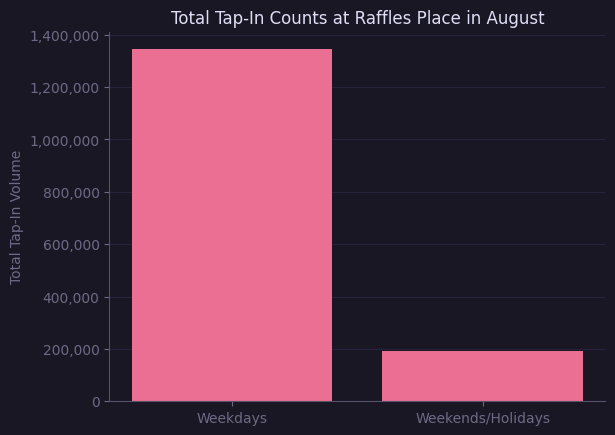

In [31]:
# Data for plotting
categories = ['Weekdays', 'Weekends/Holidays']
values = [sumOfTapInWeekday, sumOfTapInWeekend]

def create_bargraph():
# Plotting the bar graph
    plt.bar(categories, values)

    # Adding title and labels
    plt.title('Total Tap-In Counts at Raffles Place in August')
    plt.ylabel('Total Tap-In Volume')

    # Plotting the graph
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
    plt.show()

with plt.style.context("/tmp/rose-pine.mplstyle"):
    create_bargraph()